In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


In [ ]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/train_category.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/test_category.csv"
test_data = pd.read_csv(test_data_path)

In [ ]:
#keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [5]:
from imblearn.over_sampling import SMOTE
drop2 = ['loan_status', 'return']

def select_fully_paid(y_pred, method):
    scaler = StandardScaler()
    reg = LinearRegression()

    fully_paid_indices = (y_pred == 0)
    test_regression = test_data[fully_paid_indices]
    test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['loan_amnt'])/test_regression['loan_amnt']

    train_regression = data.copy()

    if method == 'Base':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['loan_amnt']

        drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt', 'grade', 'term_months','total_il_high_credit_limit', 'loan_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        data_x = train_regression.drop(columns='return')
        data_y = train_regression[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)

        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))
        return method, top_10_percent
    
    elif method == 'Undersampling':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['loan_amnt']
        drop_features = ['total_pymnt_inv', 'total_pymnt', 'grade', 'term_months','total_il_high_credit_limit', 'loan_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        X_train = train_regression.drop(columns='loan_status')
        y_train = train_regression[['loan_status']]

        undersampler = RandomUnderSampler(random_state=42)
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=X_train.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

        data_x = data_under.drop(columns=drop2)  
        data_y = data_under[['return']]  

        test_x = test_regression.drop(columns = drop2)
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)

        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent
    
    elif method == 'SMOTE':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['loan_amnt']
        drop_features = ['total_pymnt_inv', 'total_pymnt', 'grade', 'term_months','total_il_high_credit_limit', 'loan_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        X_train = train_regression.drop(columns='loan_status')
        y_train = train_regression[['loan_status']]

        smote = SMOTE(random_state=42)

        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)
        data_x = augmentation_data.drop(columns=drop2)
        data_y = augmentation_data[['return']]

        test_x = test_regression.drop(columns = drop2)
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent
    
    elif method == 'table-gan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['loan_amnt']
        drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt', 'grade', 'term_months','total_il_high_credit_limit', 'loan_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/return_feature/return_feature_OI_11_00_fake.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['loan_amnt'])/fake_regression['loan_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent
        
    elif method == 'Smotified-gan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['loan_amnt']
        drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt', 'grade', 'term_months','total_il_high_credit_limit', 'loan_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/oversampled/oversampled_OI_11_00_fake.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1
        
        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['loan_amnt'])/fake_regression['loan_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent    

In [6]:
summary_with_sharpe = []

summary_with_grade = []

def linear_portfolio(Method, top_10_indices):
    selected = test_data.loc[top_10_indices.index].copy()
    returns = (selected['total_pymnt_inv'] - selected['loan_amnt']) / selected['loan_amnt']
    
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return if std_return != 0 else np.nan

    summary_with_sharpe.append({
        'Method': Method,
        'Average Return': avg_return * 100,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio
    }) 

    A_count = len(selected[selected['grade'] == 0])
    B_count = len(selected[selected['grade'] == 1])
    C_count = len(selected[selected['grade'] == 2])
    D_count = len(selected[selected['grade'] == 3])
    E_count = len(selected[selected['grade'] == 4])
    F_G_count = len(selected[selected['grade'] == 5]) + len(selected[selected['grade'] == 6])

    summary_with_grade.append({
        'Method': Method,
        'A': A_count,
        'B': B_count,
        'C': C_count,
        'D': D_count,
        'E': E_count,
        'F+G': F_G_count,
        'Total': len(selected)
    }) 

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

def return_evaluation(model, data_x, data_y, X_test, y_test, method):
    print(f"Preprocessing method : {method}")

    if method == 'Base':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2,
                                                           random_state=42, stratify=data_y)
        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )

        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)


    elif method == 'Undersampling':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.13, random_state=42, stratify=data_y)
        undersampler = RandomUnderSampler(random_state=42)
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)
        X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
        y_train = data_under[['loan_status']]  # Target (타겟 변수)

        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'SMOTE':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)

        smote = SMOTE(random_state=42)

        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)
        X_train = augmentation_data.drop(columns='loan_status')
        y_train = augmentation_data[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'table-gan':
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/return_feature/return_feature_OI_11_00_fake.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1
        
        keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)

        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total, random_state=42)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
        
    elif method == 'Smotified-tablgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/oversampled/oversampled_OI_11_00_fake.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'vae-tablegan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/oversampled/oversampled_OI_11_00_fake.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'smotified-vae-tablegan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/oversampled/oversampled_OI_11_00_fake.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'ctgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/oversampled/oversampled_OI_11_00_fake.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'smotified-ctgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/CTGAN/ctgan_output/synthetic_smotified_ctgan_data_class1.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'vae-ctgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/oversampled/oversampled_OI_11_00_fake.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    
    #10% index뽑기기
    Method, top_10_indices = select_fully_paid(y_pred, method)

    #portfolio 만들기들기
    linear_portfolio(Method, top_10_indices)

In [ ]:
Methods = ['Base', 'Undersampling', 'SMOTE', 'table-gan','Smotified-tablegan','vae-tablegan','smotified-vae-tablegan','ctgan','smotified-ctgan','vae-ctgan']

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification['loan_status']

returns_df = pd.DataFrame()

for method in Methods:
    data_x = data_classification.drop(columns='loan_status')
    data_y = data_classification['loan_status']

    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.01,
        objective='binary:logistic',
        eval_metric="logloss",
        random_state=42,
        verbosity=0
    )

    return_evaluation(model, data_x, data_y, X_test, y_test, method)

returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

portfolio_grade_distribution_df = pd.DataFrame(summary_with_grade)

print(returns_with_sharpe_df.to_string(index=False))

Preprocessing method : Base
[0]	validation_0-logloss:0.49199	validation_1-logloss:0.49201
[1]	validation_0-logloss:0.48743	validation_1-logloss:0.48747
[2]	validation_0-logloss:0.48300	validation_1-logloss:0.48305
[3]	validation_0-logloss:0.47868	validation_1-logloss:0.47875
[4]	validation_0-logloss:0.47446	validation_1-logloss:0.47455
[5]	validation_0-logloss:0.47036	validation_1-logloss:0.47047
[6]	validation_0-logloss:0.46636	validation_1-logloss:0.46648
[7]	validation_0-logloss:0.46246	validation_1-logloss:0.46260
[8]	validation_0-logloss:0.45865	validation_1-logloss:0.45880
[9]	validation_0-logloss:0.45493	validation_1-logloss:0.45510
[10]	validation_0-logloss:0.45130	validation_1-logloss:0.45148
[11]	validation_0-logloss:0.44775	validation_1-logloss:0.44795
[12]	validation_0-logloss:0.44428	validation_1-logloss:0.44450
[13]	validation_0-logloss:0.44088	validation_1-logloss:0.44111
[14]	validation_0-logloss:0.43757	validation_1-logloss:0.43781
[15]	validation_0-logloss:0.43432	val

In [9]:
returns_with_sharpe_df.head()

,Method,Average Return,Std Dev,Sharpe Ratio
0,Base,18.464355,0.130083,1.419425
1,Undersampling,15.777935,0.112348,1.404377
2,SMOTE,16.000025,0.113756,1.406524
3,table-gan,15.615455,0.111129,1.405170
4,Smotified-gan,16.248616,0.114343,1.421038


In [10]:
portfolio_grade_distribution_df.head()

,Method,A,B,C,D,E,F+G,Total
0,Base,8852,18909,17247,8963,3969,1622,59562
1,Undersampling,14477,19382,12636,4477,1471,456,52899
2,SMOTE,14492,20081,13550,5004,1698,532,55357
3,table-gan,14810,20483,13054,4478,1414,408,54647
4,Smotified-gan,13549,19616,13630,5148,1791,570,54304


In [15]:
portfolio_grade = portfolio_grade_distribution_df.copy()

grade_columns = ['A', 'B', 'C', 'D', 'E', 'F+G']

for col in grade_columns:
    portfolio_grade[col] = (portfolio_grade[col] / portfolio_grade['Total']) * 100
    portfolio_grade[col] = round(portfolio_grade[col],2)

# 결과 출력
print(portfolio_grade[[col for col in grade_columns]])


       A      B      C      D     E   F+G
0  14.86  31.75  28.96  15.05  6.66  2.72
1  27.37  36.64  23.89   8.46  2.78  0.86
2  26.18  36.28  24.48   9.04  3.07  0.96
3  27.10  37.48  23.89   8.19  2.59  0.75
4  24.95  36.12  25.10   9.48  3.30  1.05


In [16]:
portfolio_grade.head()

,Method,A,B,C,D,E,F+G,Total
0,Base,14.86,31.75,28.96,15.05,6.66,2.72,59562
1,Undersampling,27.37,36.64,23.89,8.46,2.78,0.86,52899
2,SMOTE,26.18,36.28,24.48,9.04,3.07,0.96,55357
3,table-gan,27.10,37.48,23.89,8.19,2.59,0.75,54647
4,Smotified-gan,24.95,36.12,25.10,9.48,3.30,1.05,54304


In [30]:
# 1. 숫자 → 문자 매핑
grade_map = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G'
}

# 2. 수익률 계산
test_data['return'] = (test_data['total_pymnt_inv'] - test_data['loan_amnt']) / test_data['loan_amnt']

# 3. Fully Paid만 필터링 + 문자 등급 변환
filtered = test_data[test_data['loan_status'] == 0].copy()
filtered['grade'] = filtered['grade'].map(grade_map)

# ✅ 4. F, G → F+G로 병합
filtered['grade'] = filtered['grade'].replace({'F': 'F+G', 'G': 'F+G'})

# 5. 전체 수
total_class0 = len(filtered)

# 6. 그룹 통계 계산
grade_stats = filtered.groupby('grade').agg(
    count=('grade', 'count'),
    int_rate_avg=('int_rate', 'mean'),
    return_avg=('return', 'mean'),
    return_std=('return', 'std')
).reset_index()

# 7. 퍼센트 비율 추가
grade_stats['percentage'] = (grade_stats['count'] / total_class0) * 100

# 8. 컬럼 순서 정리
grade_stats = grade_stats[['grade', 'percentage', 'int_rate_avg', 'return_avg', 'return_std']]

# 9. 정렬 (A~E, F+G 순서)
grade_order = ['A', 'B', 'C', 'D', 'E', 'F+G']
grade_stats['grade'] = pd.Categorical(grade_stats['grade'], categories=grade_order, ordered=True)
grade_stats = grade_stats.sort_values('grade')

# 10. Total row 생성
total_row = pd.DataFrame({
    'grade': ['All'],
    'percentage': [len(filtered) / len(test_data) * 100],
    'int_rate_avg': [filtered['int_rate'].mean()],
    'return_avg': [filtered['return'].mean()],
    'return_std': [filtered['return'].std()]
})

# 11. Total 행 추가
grade_stats = pd.concat([grade_stats, total_row], ignore_index=True)

# 12. 결과 출력
grade_stats.head(10)

grade_stats['percentage'] = round(grade_stats['percentage'],2)
grade_stats['int_rate_avg'] = round(grade_stats['int_rate_avg']*100,2)
grade_stats['return_avg'] = round(grade_stats['return_avg']*100,2) 
grade_stats['return_std'] = round(grade_stats['return_std']*100,2) 


In [31]:
grade_stats.head(10)

,grade,percentage,int_rate_avg,return_avg,return_std
0,A,21.64,7.11,8.15,4.59
1,B,31.46,10.67,13.27,6.71
2,C,27.38,14.09,18.22,9.77
3,D,12.89,18.06,23.14,13.10
4,E,4.86,21.43,30.14,17.45
5,F+G,1.78,25.56,36.28,22.37
6,All,80.49,12.58,16.02,11.46


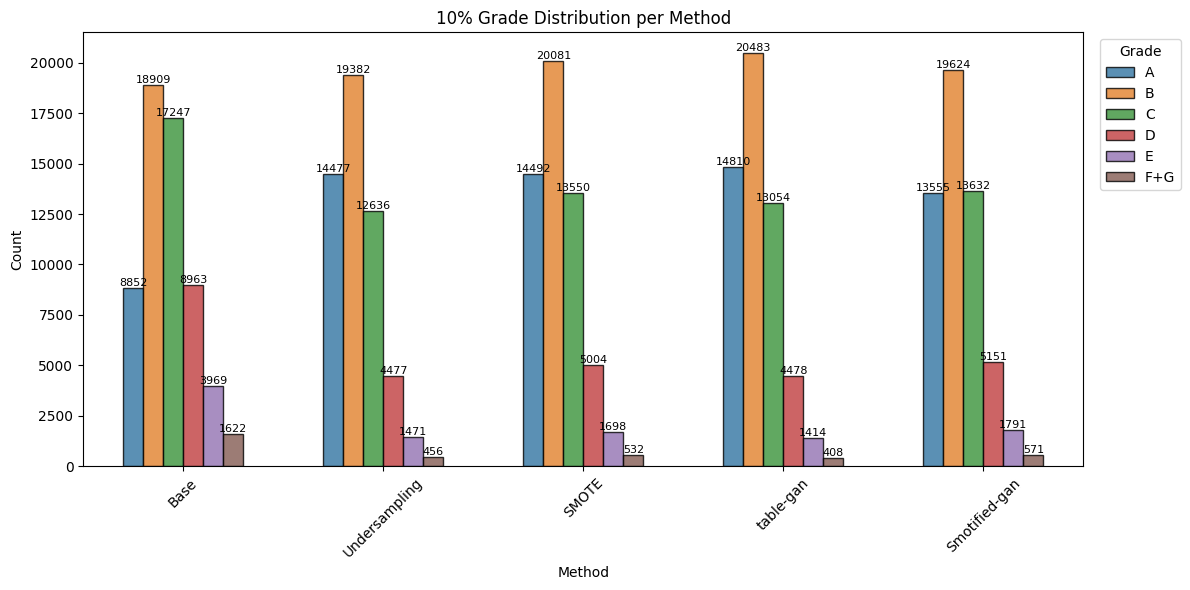

In [40]:
import seaborn as sns

df = portfolio_grade_distribution_df.drop(columns='Total')
df_melted = df.melt(id_vars="Method", var_name="Grade", value_name="Count")

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_melted,
    x="Method",
    y="Count",
    hue="Grade",
    dodge=True,
    width=0.6,
    alpha=0.8,
    edgecolor="black"
)

# 각 막대 위에 값 표시
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=8,
            rotation=0
        )

plt.title("10% Grade Distribution per Method")
plt.xticks(rotation=45)
plt.legend(title="Grade", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
"""returns_with_sharpe_df_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
returns_with_sharpe_df.to_csv(path_or_buf=returns_with_sharpe_df_path+"return_with_sharp.csv", index=False)"""

## Benchmark IRR, 무차별 투자

In [81]:
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test_irr.csv"
test_df= pd.read_csv(test_data_path)

In [95]:
import pandas as pd
import numpy as np

results = []

def calculate_benchmark_returns(df: pd.DataFrame, top_percent: float = 0.3, risk_free_rate: float = 0.0):

    # Benchmark 1: IRR 기준 상위 top_percent 투자
    df_sorted_irr = df.sort_values(by="irr", ascending=False)
    top_irr_df = df_sorted_irr.head(int(len(df_sorted_irr) * top_percent))
    
    b1_returns = top_irr_df['return']
    b1_mean = b1_returns.mean() * 100
    b1_std = b1_returns.std()
    b1_sharpe = (b1_mean - risk_free_rate) / b1_std if b1_std != 0 else np.nan

    results.append({
        'portfolio': "benchmark1",
        'Average Return': b1_mean,
        'Std Dev': b1_std,
        'Sharpe Ratio': b1_sharpe
    }) 

    # Benchmark 2: 전체 무차별 투자
    b2_returns = df['return']
    b2_mean = b2_returns.mean() * 100
    b2_std = b2_returns.std() 
    b2_sharpe = (b2_mean - risk_free_rate) / b2_std if b2_std != 0 else np.nan

    results.append({
        'portfolio': "benchmark2",
        'Average Return': b2_mean,
        'Std Dev': b2_std,
        'Sharpe Ratio': b2_sharpe
    }) 

    return results  


In [96]:
calculate_benchmark_returns(test_df)

benchmark_df = pd.DataFrame(results)

In [97]:
benchmark_df.head()

,portfolio,Average Return,Std Dev,Sharpe Ratio
0,benchmark1,2.799690,0.383814,7.294384
1,benchmark2,4.351517,0.288939,15.060314


In [ ]:
"""import numpy_financial as npf

def calculate_irr(loan_amnt, installment, term_months):
    cash_flows = [-loan_amnt] + [installment] * term_months
    return npf.irr(cash_flows)


test_data['irr'] = test_data.apply(
    lambda row: calculate_irr(row['loan_amnt'], row['installment'], int(row['term_months'])),
    axis=1
)

test_data_irr_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
test_data.to_csv(path_or_buf=test_data_irr_path+"return_feature_test_irr.csv", index=False)"""